# Multi-Class Prediction of Obesity Risk


## Processo de desenvolvimento do modelo


## Preparação do ambiente e dos dados


### Imports e Configurações Gerais


In [73]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_validate, cross_val_predict, train_test_split
from sklearn.metrics import (
    make_scorer,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    classification_report,
    confusion_matrix,
)

from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier

%matplotlib inline

# seaborn.set_theme()

### Funções


#### show_stats ( )


In [2]:
def show_stats(dataframe):
    """
    Retorna dataframe contendo a contagem de valores inválidos (None, NaN, NaT) em cada coluna do dataframe passado como parâmetro.
    """

    data_dict = {
        c: [
            dataframe.columns[c],
            (dataframe.shape[0] - dataframe[dataframe.columns[c]].count()),
            len(dataframe[dataframe.columns[c]].unique()),
            dataframe[dataframe.columns[c]].dtype,
        ]
        for c in range(len(dataframe.columns))
    }

    return pd.DataFrame(
        data=data_dict, index=["Nome", "Val. inválidos", "Val. únicos", "Tipo"]
    ).T

### Carregamento dos Dados


In [ ]:
train = pd.read_csv("../data/train.csv")
test = pd.read_csv("../data/test.csv")

## Análise Exploratória


### Visão Geral


Os dados estão todos completos, sem valores faltantes ou evidentemente inválidos (ex: NaN) em nenhuma coluna.

Há [Informações sobre o significado de cada coluna](https://www.kaggle.com/competitions/playground-series-s4e2/discussion/472516) em comentário no Kaggle.


In [4]:
train.head()

,id,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
0,0,Male,24.443011,1.699998,81.669950,yes,yes,2.000000,2.983297,Sometimes,no,2.763573,no,0.000000,0.976473,Sometimes,Public_Transportation,Overweight_Level_II
1,1,Female,18.000000,1.560000,57.000000,yes,yes,2.000000,3.000000,Frequently,no,2.000000,no,1.000000,1.000000,no,Automobile,Normal_Weight
2,2,Female,18.000000,1.711460,50.165754,yes,yes,1.880534,1.411685,Sometimes,no,1.910378,no,0.866045,1.673584,no,Public_Transportation,Insufficient_Weight
3,3,Female,20.952737,1.710730,131.274851,yes,yes,3.000000,3.000000,Sometimes,no,1.674061,no,1.467863,0.780199,Sometimes,Public_Transportation,Obesity_Type_III
4,4,Male,31.641081,1.914186,93.798055,yes,yes,2.679664,1.971472,Sometimes,no,1.979848,no,1.967973,0.931721,Sometimes,Public_Transportation,Overweight_Level_II


In [5]:
show_stats(train)

,Nome,Val. inválidos,Val. únicos,Tipo
0,id,0,20758,int64
1,Gender,0,2,object
2,Age,0,1703,float64
3,Height,0,1833,float64
4,Weight,0,1979,float64
5,family_history_with_overweight,0,2,object
6,FAVC,0,2,object
7,FCVC,0,934,float64
8,NCP,0,689,float64
9,CAEC,0,4,object


In [ ]:
binary_columns = ["Gender", "family_history_with_overweight", "FAVC", "SMOKE", "SCC"]
categorical_columns = ["CAEC", "CALC", "MTRANS", "NObeyesdad"]
numerical_columns = ["Age", "Height", "Weight", "FCVC", "NCP", "CH2O", "FAF", "TUE"]

### Atributos categóricos


#### Gender


Pela característica do atributo (não ter uma ordem), certamente vamos utilizar o One Hot Encoding. Que neste caso será como um atributo binário porque por conta da opção drop="First" que será usada.


In [7]:
print(train.Gender.unique())
print(test.Gender.unique())

['Male' 'Female']
['Male' 'Female']


In [ ]:
gender_options = ["Male", "Female"]

#### CALC


Para este atributo há uma ordem muito clara entre as classes, de maneira que podemos fazer ordinal encoding, mas também podemos fazer one hot encoding, que possui a vantagem de não atribuir uma escala às classes. Mas ambos os métodos podem ser testados.


In [9]:
print(train.CALC.unique())
print(test.CALC.unique())

['Sometimes' 'no' 'Frequently']
['Sometimes' 'no' 'Frequently' 'Always']


In [ ]:
CALC_options = ["no", "Sometimes", "Frequently", "Always"]

#### MTRANS


Neste atributo podemos proceder de duas maneiras principais:

- Utilizar One Hot Encoding. Escolha que considero mais certeira por não atribuir ordem ou escala.
- Definir uma ordem e utilizar ordinal encoding. Neste caso podemos olhar o comportamento do atributo em relação ao target para validar a ordem escolhida para cada classe.


In [11]:
print(train.MTRANS.unique())
print(test.MTRANS.unique())

['Public_Transportation' 'Automobile' 'Walking' 'Motorbike' 'Bike']
['Public_Transportation' 'Automobile' 'Walking' 'Bike' 'Motorbike']


In [ ]:
MTRANS_options = ["Walking", "Public_Transportation", "Bike", "Motorbike", "Automobile"]

#### NObeyesdad (Target)


Para este atributo será feito ordinal encoding, porque há uma ordem clara entre as classes e este é o target, portanto está é a técnica mais usual para que a saída do algoritmo possa ser numérica.


In [13]:
print(train.NObeyesdad.unique())

['Overweight_Level_II' 'Normal_Weight' 'Insufficient_Weight'
 'Obesity_Type_III' 'Obesity_Type_II' 'Overweight_Level_I'
 'Obesity_Type_I']


In [ ]:
target_order = [
    "Insufficient_Weight",
    "Normal_Weight",
    "Overweight_Level_I",
    "Overweight_Level_II",
    "Obesity_Type_I",
    "Obesity_Type_II",
    "Obesity_Type_III",
]

### Matriz de dispersão


In [ ]:
sns.set_theme(style="ticks")
# plot = sns.pairplot(train.sample(1000), plot_kws={'alpha':0.1})
# plot = sns.pairplot(train, plot_kw  s={'alpha':0.05})

## Construção do modelo

### Separação das Labels


In [16]:
target_encoder = OrdinalEncoder(categories=[target_order], dtype=int)

train["NObeyesdad_encoded"] = target_encoder.fit_transform(
    train[["NObeyesdad"]]
).flatten()

features = train.drop(["NObeyesdad", "NObeyesdad_encoded"], axis=1)
target = train["NObeyesdad_encoded"]

### Definição do modelo

In [ ]:
preprocessor = ColumnTransformer(
    transformers=[
        (
            "numerical",
            "passthrough",
            numerical_columns,
        ),
        (
            "Gender",
            OneHotEncoder(
                categories=[gender_options], drop="first", sparse_output=False
            ),
            ["Gender"],
        ),
        (
            "CALC",
            OneHotEncoder(categories=[CALC_options], drop="first", sparse_output=False),
            ["CALC"],
        ),
        # ('CALC', OrdinalEncoder(categories=[CALC_options], dtype=int), ['CALC']),
        (
            "MTRANS",
            OneHotEncoder(
                categories=[MTRANS_options], drop="first", sparse_output=False
            ),
            ["MTRANS"],
        ),
    ]
)

model = Pipeline(
    steps=[("preprocessor", preprocessor), ("model", RandomForestClassifier())]
)


### Visualização detalhada do desempenho de um modelo (Playgroung)

#### Treino e teste (Substituída pela validação cruzada)


Esta seção foi mantida apenas para mostrar o progresso de desenvolvimento, mas todo o relatório de classificação feito aqui, foi refeito (e aprimorado) com validação cruzada, que dá mais confiabilidade a todas as métricas por calculá-las sobre todo o conjunto de dados.

In [70]:
X_train, X_test, y_train, y_test = train_test_split(
    features, target, test_size=0.2, random_state=42
)

model.fit(X_train, y_train)


y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"\nAcurácia do modelo: {accuracy:.3f}")

print("\nRelatório de Classificação:")
print(
    classification_report(
        y_test,
        y_pred,
        target_names=target_order,
    )
)


Acurácia do modelo: 0.885

Relatório de Classificação:
                     precision    recall  f1-score   support

Insufficient_Weight       0.93      0.92      0.93       524
      Normal_Weight       0.84      0.87      0.86       626
 Overweight_Level_I       0.74      0.71      0.73       484
Overweight_Level_II       0.75      0.77      0.76       514
     Obesity_Type_I       0.88      0.86      0.87       543
    Obesity_Type_II       0.98      0.97      0.97       657
   Obesity_Type_III       1.00      1.00      1.00       804

           accuracy                           0.89      4152
          macro avg       0.87      0.87      0.87      4152
       weighted avg       0.89      0.89      0.89      4152



#### Relatório de classificação detalhado 

Vamos obter predições para todo o conjunto de treino através de validação cruzada.

In [ ]:
y_pred_cv = cross_val_predict(
    model,
    features,
    target,
    cv=5,
    method="predict",
)

A seguir vemos um relatório geral de classificação para o modelo escolhido, que apresenta métricas de desempenho gerais e para cada uma das classes do atributo que queremos estimar.

In [79]:
print(f"\nAcurácia do modelo: {accuracy_score(target, y_pred_cv):.3f}")
print("\nRelatório de Classificação:")
print(classification_report(target, y_pred_cv, target_names=target_order))


Acurácia do modelo: 0.891

Relatório de Classificação:
                     precision    recall  f1-score   support

Insufficient_Weight       0.92      0.92      0.92      2523
      Normal_Weight       0.85      0.88      0.86      3082
 Overweight_Level_I       0.76      0.71      0.74      2427
Overweight_Level_II       0.77      0.78      0.77      2522
     Obesity_Type_I       0.89      0.88      0.88      2910
    Obesity_Type_II       0.97      0.97      0.97      3248
   Obesity_Type_III       1.00      1.00      1.00      4046

           accuracy                           0.89     20758
          macro avg       0.88      0.88      0.88     20758
       weighted avg       0.89      0.89      0.89     20758



Para detalhar mais o comportamento que o modelo segue em cada uma das classes, a seguir apresentamos a matriz de confusão.

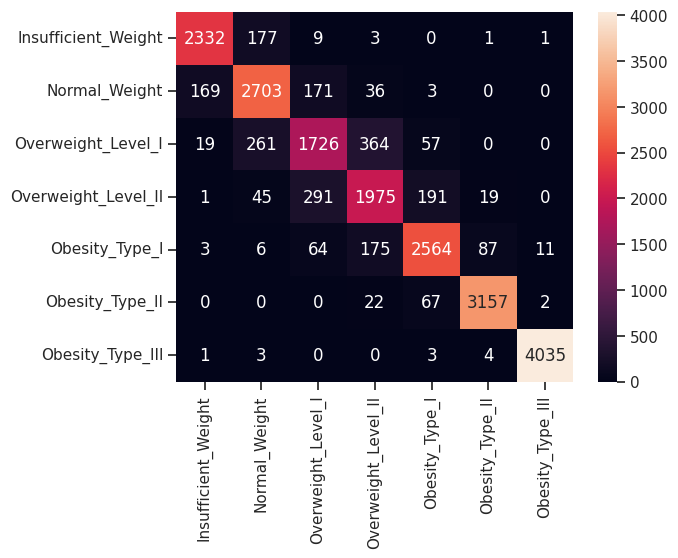

In [ ]:
sns.heatmap(
    confusion_matrix(target, y_pred_cv),
    annot=True,
    fmt="d",
    xticklabels=target_order,
    yticklabels=target_order,
);

#### Comparação entre desempenho de treino e teste

In [87]:
scoring = {
    "accuracy": make_scorer(accuracy_score),
    "precision_macro": make_scorer(precision_score, average="macro"),
    "recall_macro": make_scorer(recall_score, average="macro"),
    "f1_macro": make_scorer(f1_score, average="macro"),
}

cv_results = cross_validate(
    model,
    features,
    target,
    cv=5,
    # cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    scoring=scoring,
    return_train_score=True,
)


In [99]:
# Criar um DataFrame com os resultados por fold
results_per_fold = pd.DataFrame({
    # 'Fold': range(1, 6),  # Assumindo 5 folds
    'Acurácia (Treino)': cv_results['train_accuracy'],
    'Acurácia (Teste)': cv_results['test_accuracy'],
    'Precisão (Treino)': cv_results['train_precision_macro'],
    'Precisão (Teste)': cv_results['test_precision_macro'],
    'Recall (Treino)': cv_results['train_recall_macro'],
    'Recall (Teste)': cv_results['test_recall_macro'],
    'F1-Score (Treino)': cv_results['train_f1_macro'],
    'F1-Score (Teste)': cv_results['test_f1_macro']
})

# Adiciona médias ao final
results_per_fold.loc['Média'] = results_per_fold.mean()
results_per_fold.loc['Desvio Padrão'] = results_per_fold.std()

print("\nMétricas por Fold, com Média e Desvio Padrão:")
display(results_per_fold.round(3))


Métricas por Fold, com Média e Desvio Padrão:


,Acurácia (Treino),Acurácia (Teste),Precisão (Treino),Precisão (Teste),Recall (Treino),Recall (Teste),F1-Score (Treino),F1-Score (Teste)
0,0.998,0.887,0.998,0.876,0.998,0.874,0.998,0.875
1,0.998,0.883,0.998,0.871,0.998,0.869,0.998,0.869
2,0.998,0.902,0.998,0.892,0.998,0.892,0.998,0.892
3,0.998,0.895,0.998,0.884,0.998,0.882,0.998,0.883
4,0.998,0.890,0.998,0.878,0.998,0.877,0.998,0.877
Média,0.998,0.891,0.998,0.880,0.998,0.879,0.998,0.879
Desvio Padrão,0.000,0.007,0.000,0.007,0.000,0.008,0.000,0.008


In [82]:
metrics_df = pd.DataFrame(
    {
        "Métrica": [
            "Acurácia",
            "Precisão",
            "Recall",
            "F1-score",
        ],
        "Média (Treino)": [
            np.mean(cv_results["train_accuracy"]),
            np.mean(cv_results["train_precision_macro"]),
            np.mean(cv_results["train_recall_macro"]),
            np.mean(cv_results["train_f1_macro"]),
        ],
        "Std. Dev. (Treino)": [
            np.std(cv_results["train_accuracy"]),
            np.std(cv_results["train_precision_macro"]),
            np.std(cv_results["train_recall_macro"]),
            np.std(cv_results["train_f1_macro"]),
        ],
        "Média (Teste)": [
            np.mean(cv_results["test_accuracy"]),
            np.mean(cv_results["test_precision_macro"]),
            np.mean(cv_results["test_recall_macro"]),
            np.mean(cv_results["test_f1_macro"]),
        ],
        "Std. Dev. (Teste)": [
            np.std(cv_results["test_accuracy"]),
            np.std(cv_results["test_precision_macro"]),
            np.std(cv_results["test_recall_macro"]),
            np.std(cv_results["test_f1_macro"]),
        ],
    }
)

metrics_df = metrics_df.round(3)

print("\nTabela de Métricas:")
display(metrics_df)


Tabela de Métricas:


,Métrica,Média (Treino),Std. Dev. (Treino),Média (Teste),Std. Dev. (Teste)
0,Acurácia,0.998,0.0,0.892,0.006
1,Precisão,0.998,0.0,0.880,0.007
2,Recall,0.998,0.0,0.879,0.007
3,F1-score,0.998,0.0,0.879,0.007


### Treinamento final

In [ ]:
model.fit(features, target)

## Predição


In [ ]:
prediction = model.predict(test)
predicted_classes = target_encoder.inverse_transform(
    prediction.reshape(-1, 1)
).flatten()

predicted_df = pd.DataFrame({"id": test.id, "NObeyesdad": predicted_classes})

predicted_df.to_csv("../submission/submission.csv", index=False)